# Autoregressive Moving Average (ARMA)
- How to treat time series where you cannot infer an order from the ACF plot or from the PACF plot. 
    - This means that both figures exhibit a slowly decaying pattern or a sinusoidal pattern. 
    - In such a case, we are in the presence of an autoregressive moving average, $ARMA(p,q)$, where 
        - $p$ denotes the order of the autoregressive portion
        - $q$ denotes the order of the moving average portion.
- As using the ACF and PACF plots to determine the orders $q$ and $p$, respectively, becomes difficult, **general modeling procedure** will involve using the Akaike information criterion (AIC), which will determine the optimal combination of p and q for our series.

In [32]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product
from tqdm import tqdm
from typing import Union
import warnings

np.random.seed(42)  
warnings.filterwarnings('ignore')

## Introduction
- The autoregressive moving average process $ARMA(p,q)$ is a combination of the autoregressive process and the moving average process. 
- The $ARMA(p,q)$ process is expressed as a linear combination of
    - On its own previous values $y_{t-p}$ and a constant $C$, just like in an *autoregressive* process
    - On the mean of the series $\mu$, the current error term $\epsilon_t$, and past error terms $\epsilon_{t-q}$, like in a *moving average* process. 

$$y_t = C + \epsilon_t + \varphi_1y_{t–1} + \varphi_2y_{t–2} +⋅⋅⋅+ \varphi_p y_{t–p} + \mu + \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q}$$

## Identifying a stationary ARMA process
<p align="center"><img src="../../assets/img/arma-identification-framework.png" height=700><br>Steps to identify a random walk, a moving average process MA(q), an autoregressive process AR(p), and an autoregressive moving average process ARMA(p, q)</p>

- If neither of the ACF and PACF plots shows a clear cutoff between significant and non-significant coefficients, then we have an ARMA(p,q) process. 

- Simulate an ARMA(1,1) process with the below equation.
    - This is equivalent to combining an MA(1) process with an AR(1) process. 
$$y_t = 0.33y_{t-1} + 0.9\epsilon_{t-1} + \epsilon_t$$

- Use the `ArmaProcess` function from the `statsmodels` library to simulate our ARMA(1,1) process. 
    - AR(1) process will have a coefficient of 0.33.
        - However, the function expects to have the coefficient of the autoregressive process with its opposite sign, so it is –0.33. 
    - MA(1) process will have a coefficient is 0.9
    - Note: when defining your arrays of coefficients, the first coefficient is always equal to 1, as specified by the library, which represents the coefficient at lag 0. 

In [33]:
ar1 = np.array([1, -0.33])                                        
ma1 = np.array([1, 0.9])                                          
 
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)   

In [34]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [35]:
check_stationarity(ARMA_1_1)

ADF Statistic : -6.42988, p-value: 0.00000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
KPSS Statistic: 0.20119, p-value: 0.10000
Stationary


- The simulated ARMA(1,1) process is stationary.

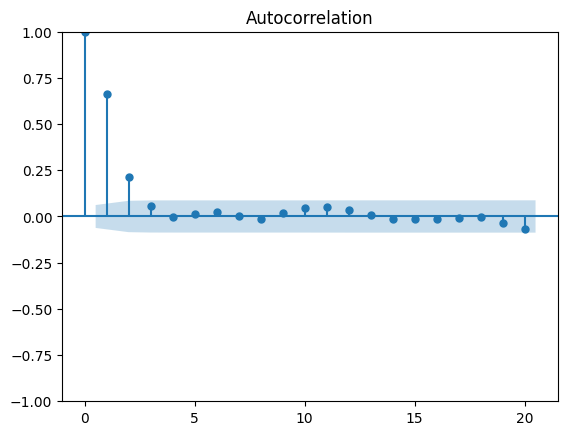

In [36]:
plot_acf(ARMA_1_1, lags=20);

- From the ACF plot, there is a sinusoidal pattern in the plot, which indicates the presence of an autoregressive process. This is expected, since we simulated an ARMA(1,1) process and we know of the existence of the autoregressive portion.
- Alos, the last significant coefficient is at lag 2. We know that our simulated data has an MA(1) process, so we would expect to have significant coefficients up to lag 1 only. 

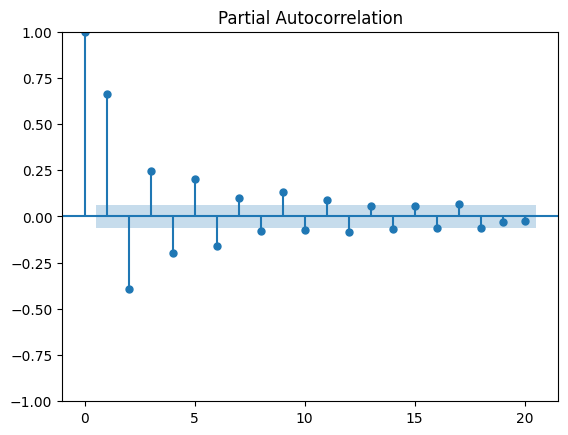

In [37]:
plot_pacf(ARMA_1_1, lags=20);

- From the PACF plot, there is a clear sinusoidal pattern, meaning that we cannot infer a value for the order $p$.
- If your process is stationary and both the ACF and PACF plots show a decaying or sinusoidal pattern, then it is a stationary ARMA(p,q) process.
- Since the ACF and PACF plots are not useful in the case of an ARMA(p,q) process, we must thus devise a general modeling procedure that will allow us to find the appropriate combination of (p,q) for our model.

## Devising a general modeling procedure
- Neither ACF nor PACF plot was useful for determining the orders p and q, so we rely entirely on a model selection criterion and residual analysis.

<p align="center"><img src="../../assets/img/general-modeling-procedure-for-arma-process.png" height=700><br>General modeling procedure for an ARMA(p, q) process.</p>

- Step 1: Test for stationarity, and apply transformations accordingly.
- Step 2: List different possible values of p and q
- Step 3: Fit every unique combination of ARMA(p,q) to our data.
    - Compute the Akaike information criterion (AIC) & the model with the lowest AIC is then selected.
- Step 4: perform the residual analysis (the difference between the actual and predicted values of the model) by looking at 
    - The quantile-quantile plot (Q-Q plot): to check if the residuals are normally distributed
    - The residual correlogram. (Ljung-Box test): to check if the residuals are uncorrelated.
    - Note: a good model has residuals that are similar to white noise, so the residuals should be normally distributed and uncorrelated.
- If the analysis leads us to conclude that the residuals are completely random, we have a model ready for forecasting.
- Otherwise, we must try a different set of values for p and q and start the process over.

### Akaike information criterion (AIC)
- Given that there will be some information lost when a model is fitted to the data, the AIC quantifies the relative amount of information lost by the model. 
- The less information lost, the lower the AIC value and the better the model.

In [38]:
# define a list of (p, q)
 
ps = range(0, 4, 1)  # p varies from 0 to 3             
qs = range(0, 4, 1)  # q varies from 0 to 3            
 
order_list = list(product(ps, qs))

In [39]:
# fit all unique 16 ARMA(p,q) models to the data
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            p, q = order
            model = SARIMAX(endog, 
                            order=(p, 0, q), 
                            simple_differencing=False # prevent differencing.
                            ).fit(disp=False) # avoid printing convergence messages to the console.
        except:
            continue
        # calculate the model’s AIC. 
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [40]:
result_df = optimize_ARMA(ARMA_1_1, order_list) 
result_df.head()

100%|██████████| 16/16 [00:01<00:00, 13.50it/s]


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027


- The model with the lowest AIC corresponds to an ARMA(1,1) model.
- The residuals of a model are simply the difference between the predicted values and the actual values.

### Residual Analysis
- Using the AIC as a model selection criterion, we found that an $ARMA(1,1)$ model is the best model 
#### Qualitative analysis: Studying the Q-Q plot
- The first step in residual analysis is the study of the quantile-quantile plot (Q-Q plot). 
- The Q-Q plot is a graphical tool for verifying our **hypothesis that the model’s residuals are normally distributed** because we want the residuals to be similar to white noise, which is normally distributed.

Q-Q plot of residuals that are very close to a normal distribution           |  Q-Q plot of residuals that are not close to a normal distribution.
:-------------------------:|:-------------------------:
![](../../assets/img/qq-plot-randomly-distributed-residuals.png)  |  ![](../../assets/img/qq-plot-residuals-not-close-to-normal-distribution.png)
- The Q-Q plot is constructed by plotting the quantiles of our residuals on the y-axis against the quantiles of a theoretical distribution, in this case the normal distribution, on the x-axis.
    - If both distributions are similar, meaning that the distribution of the residuals is close to a normal distribution, the Q-Q plot will display a straight line that approximately lies on y = x. 
    - If both distributions are not similar, meaning that the distribution of the residuals is not close to a normal distribution, the Q-Q plot will generate the curve that departs from y = x. 
#### Quantitative analysis: Applying the Ljung-Box test
- Once we have analyzed the Q-Q plot and determined that our residuals are approximately normally distributed, we can then apply the Ljung-Box test to demonstrate that the residuals are uncorrelated. 
- Note: a good model has residuals that are similar to white noise, so the residuals should be normally distributed and uncorrelated.
- The Ljung-Box test is a statistical test that determines whether the autocorrelation of a group of data is significantly different from 0.
    - In time series forecasting, we apply the Ljung-Box test on the model’s residuals to test whether they are similar to white noise.
    - The null hypothesis states that the data is independently distributed, meaning that there is no autocorrelation. 
    - If the p-value is > 0.05, we cannot reject the null hypothesis, meaning that the residuals are independently distributed. 
        - Therefore, there is no autocorrelation, the residuals are similar to white noise, and the model can be used for forecasting.
    - If the p-value is < 0.05, we reject the null hypothesis, meaning that our residuals are not independently distributed and are correlated. The model cannot be used for forecasting.

In [43]:
# To perform residual analysis, we need to fit our model and store the residuals in a variable for easy access.
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid  # Store the model’s residuals

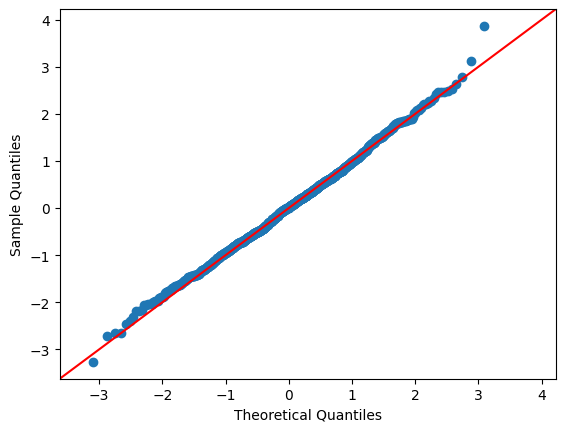

In [44]:
from statsmodels.graphics.gofplots import qqplot
# to display our residuals against a normal distribution.
qqplot(residuals, line='45');

- From the Q-Q plot, there is a thick straight line that approximately lies on y = x. 
- Therefore, from a qualitative standpoint, the model’s residuals seem to be *normally distributed*, just like *white noise*, which is an indication that our model fits the data well.

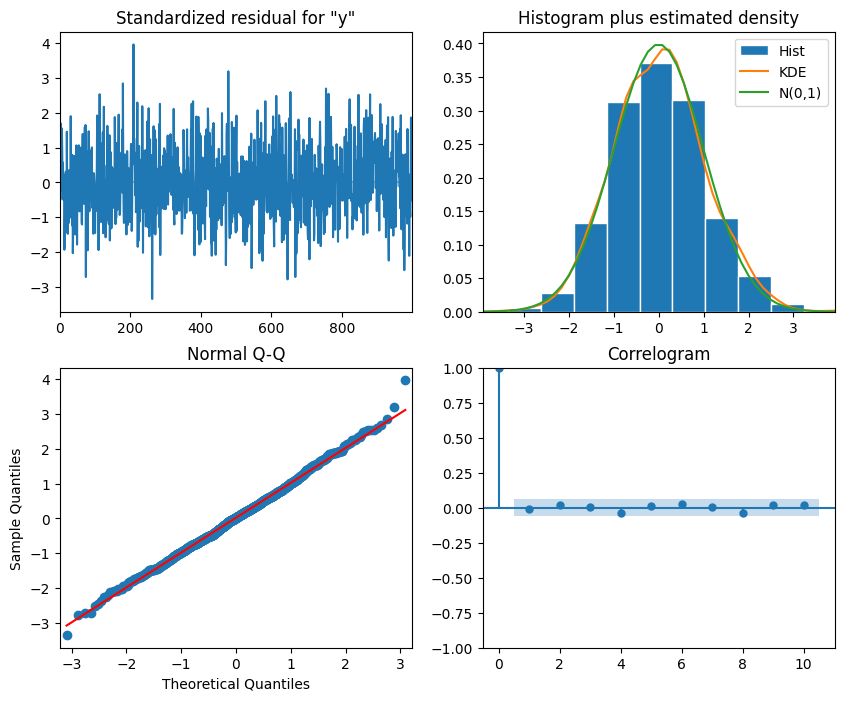

In [46]:
# extend our qualitative analysis by using the plot_diagnostics method. This generates a figure containing four different plots, including a Q-Q plot.
model_fit.plot_diagnostics(figsize=(10, 8));

- The top-left plot shows the residuals across the entire dataset. You can see that there is no trend, and the mean seems stable over time, which is indicative of stationarity, just like white noise.
- The top-right plot shows a histogram of the residuals. You can see the shape of a normal distribution on this plot, which again indicates that the residuals are close to white noise, as white noise is normally distributed as well.
- From the bottom left, we have the Q-Q plot, and therefore leads us to the same conclusion.
- From the bottom-right, the plot shows the autocorrelation function of our residuals
    - There is only a significant peak at lag 0, and no significant coefficients otherwise.

In [59]:
# The final step in residual analysis is applying the Ljung-Box test.
from statsmodels.stats.diagnostic import acorr_ljungbox
 
acorr_ljungbox(residuals, 
                np.arange(1, 11, 1), # compute the Ljung-Box statistic and p-value for 10 lags.
)  

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


- The resulting list of p-values shows that each is above 0.05.
- Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated.